<a href="https://colab.research.google.com/github/DarioDell/convolutional_neural_networks-CNN-/blob/main/Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Localization

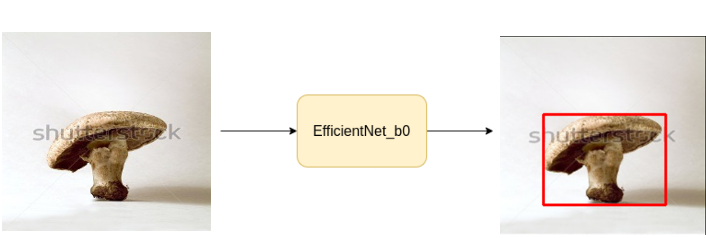

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations

!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-vtlh24uu
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-vtlh24uu
  Resolved https://github.com/albumentations-team/albumentations to commit 20098f440dbbf7ace5eeb1f1f3b093e34be80177
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.6/291.6 kB 10.6 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.18-py3-none-any.whl size=225731 sha256=e1453dfb163296f87e9a0248a1a8077463ddd9dbcf9e89af3570fcbe822df80d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tsvsm_ir/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4aa3df33aacb3da0da29b93
Successfully built albumentations
  Attempting uninstall: albu

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 2.73 MiB | 6.57 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from torch import nn
import timm

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:

CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset'
DEVICE = 'cuda'


DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
NUM_EPOCHS = 40
MODEL_NAME = 'tf_efficientnet_b0_ns'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

/content/object-localization-dataset/train_images/mushroom_20.jpg


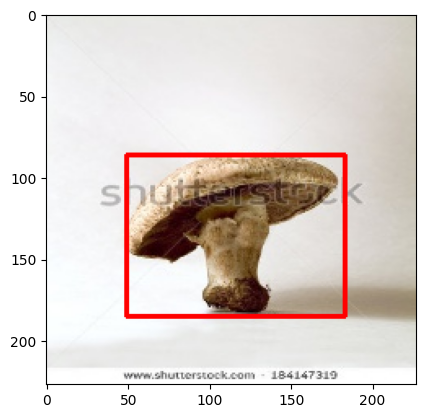

In [ ]:
import os

row = df.iloc[2]
# Use os.path.join to ensure the path is correct
file_path = os.path.join(DATA_DIR, row.img_path)

# Print the corrected route
print(file_path)

# Load image using corrected path
img = cv2.imread(file_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (int(row.xmin), int(row.ymin))
pt2 = (int(row.xmax), int(row.ymax))
bnd_box_img = cv2.rectangle(img,pt1, pt2,(255,0,0),2)
plt.imshow(bnd_box_img)
plt.show()


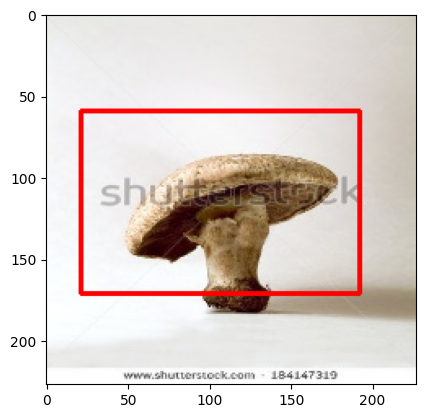

In [ ]:
row = df.iloc[184]
img = cv2.imread(file_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (int(row.xmin), int(row.ymin))
pt2 = (int(row.xmax), int(row.ymax))
bnd_box_img = cv2.rectangle(img,pt1, pt2,(255,0,0),2)
plt.imshow(bnd_box_img)
plt.show()

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5)

    # Add more transformations according to your needs
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

valid_augs = A.Compose([
    A.Resize(224, 224)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    xmins = row.xmin
    xmaxs = row.xmax
    ymins = row.ymin
    ymaxs = row.ymax

    bbox = [[xmins, ymins, xmaxs, ymaxs]]


    img_path = os.path.join(DATA_DIR, row.img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      augmented = self.augmentations(image=img, bboxes=bbox, class_labels=[row.label])
      img = augmented['image']
      bbox = torch.tensor(augmented['bboxes'][0], dtype=torch.float32)

    img = img.astype(np.float32)
    img /= 255.0
    img = img.transpose(2, 0, 1)
    img = torch.tensor(img, dtype=torch.float32)

    return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f'Total examples in the Trainset : {len(trainset)}')
print(f'Total examples in the Validset : {len(validset)}')

Total examples in the Trainset : 148
Total examples in the Validset : 38


Shape of image : torch.Size([3, 224, 224])
Shape of bbox : torch.Size([4])


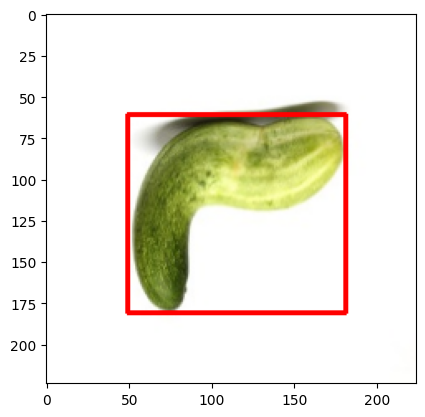

In [ ]:
img, bbox = trainset[34]
print(f'Shape of image : {img.shape}')
print(f'Shape of bbox : {bbox.shape}')

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 16, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size= 16, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  print("Shape of one batch images : {}".format(images.shape))
  print("Shape of one batch bboxes : {}".format(bboxes.shape))
  break;


Shape of one batch images : torch.Size([16, 3, 224, 224])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model('tf_efficientnet_b0_ns', pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes = None):

    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)

      return bboxes, loss

    return bboxes


In [ ]:
model = ObjLocModel()
model.to(DEVICE)


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16

In [ ]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):
    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()

  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

#Inference

In [ ]:
import utils

In [ ]:
best_valid_loss = np.inf

for i in range(NUM_EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHT ARE SAVED!")
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1}')
  print(f'Train Loss : {train_loss:.4f}')
  print(f'Valid Loss : {valid_loss:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 1
Train Loss : 15715.4989
Valid Loss : 1847.4540


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 2
Train Loss : 9909.6286
Valid Loss : 2646.8148


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 3
Train Loss : 8384.3469
Valid Loss : 4128.3241


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 4
Train Loss : 7124.6509
Valid Loss : 5790.7340


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5
Train Loss : 6138.9431
Valid Loss : 5687.8582


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 6
Train Loss : 5694.1462
Valid Loss : 5190.0848


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7
Train Loss : 5116.8270
Valid Loss : 4893.7285


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8
Train Loss : 4442.9583
Valid Loss : 5057.2467


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9
Train Loss : 3904.1091
Valid Loss : 3633.1369


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10
Train Loss : 3341.5982
Valid Loss : 2719.0408


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11
Train Loss : 3134.0669
Valid Loss : 2550.0270


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12
Train Loss : 2790.5108
Valid Loss : 2579.6125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13
Train Loss : 2582.4611
Valid Loss : 2044.5612


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14
Train Loss : 2072.1677
Valid Loss : 2196.6142


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 15
Train Loss : 1844.1878
Valid Loss : 1743.1073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 16
Train Loss : 1448.7730
Valid Loss : 1397.3805


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 17
Train Loss : 1278.2444
Valid Loss : 1218.2209


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 18
Train Loss : 1207.8401
Valid Loss : 1048.8724


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 19
Train Loss : 1033.6702
Valid Loss : 875.5099


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 20
Train Loss : 837.8672
Valid Loss : 848.1667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 21
Train Loss : 761.5549
Valid Loss : 591.1068


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 22
Train Loss : 570.5266
Valid Loss : 546.6712


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 23
Train Loss : 592.1791
Valid Loss : 463.6711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 24
Train Loss : 421.5928
Valid Loss : 401.0352


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 25
Train Loss : 372.4232
Valid Loss : 375.6554


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26
Train Loss : 353.4164
Valid Loss : 450.4490


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 27
Train Loss : 326.7609
Valid Loss : 325.9771


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28
Train Loss : 247.6497
Valid Loss : 400.1721


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 29
Train Loss : 243.9755
Valid Loss : 310.8638


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 30
Train Loss : 233.3774
Valid Loss : 270.9416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 31
Train Loss : 179.5006
Valid Loss : 264.1555


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 32
Train Loss : 192.0000
Valid Loss : 230.4998


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 33
Train Loss : 166.3082
Valid Loss : 212.3404


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34
Train Loss : 154.5486
Valid Loss : 282.0476


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 35
Train Loss : 158.6406
Valid Loss : 167.1622


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHT ARE SAVED!
Epoch : 36
Train Loss : 146.4706
Valid Loss : 159.6592


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37
Train Loss : 136.4851
Valid Loss : 190.8258


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38
Train Loss : 121.6859
Valid Loss : 198.5782


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39
Train Loss : 139.5251
Valid Loss : 195.7798


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40
Train Loss : 128.3387
Valid Loss : 169.7247


<ipython-input-34-d76c172ad417>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


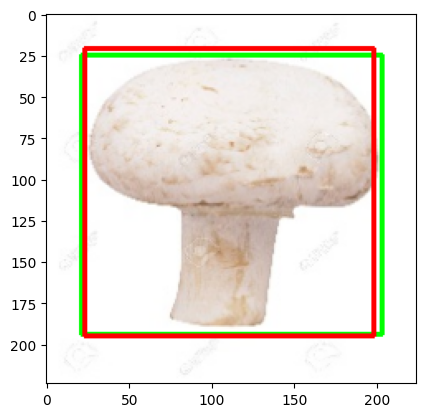

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

     image, gt_bbox = validset[1] # (c, h, w)
     image = image.unsqueeze(0).to(DEVICE) # (1, c, h, w)
     out_bbox = model(image)

     utils.compare_plots(image, gt_bbox, out_bbox)

